## 1. <font color = red> Install and Import the Required Libraries

In [1]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:0

In [2]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [4]:
# Define the path of the PDF
single_pdf_path = '/content/drive/MyDrive/Colab Notebooks/Help-Mate-AI/Principal-Sample-Life-Insurance-Policy.pdf'

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [5]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[50]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Coverage During Disability will cease on the earliest of:
(1) the date the Member's Total Disability ends; or
(2) the date the Member fails to send The Principal any required proof of ADL Disability
or Total Disability; or
(3) the date the Member ceases to be under the regular care and attendance of a
Physician; or
(4) the date the Member fails to submit to a required Medical Examination or Evaluation;
or
(5) the date the Member attains age 70.
g. Limitations
No benefits will be paid for any disability that:
(1) results from willful self-injury or self-destruction, while sane or insane; or
(2) results from war or act of war; or
(3) results from voluntary participation in an assault, felony, criminal activity,
insurrection, or riot.
Article 7 - Accelerated Benefits
a. Accelerated Benefits Qualification
To be qualified for an Accelerated Benefit payment, a Member must:
(1) be Terminally Ill and insured for a Member Life Insurance benefit of at least $10,000;
and
(2) send a request for Ac

In [6]:
# View the table in the page, if any

len(tables)

0

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [7]:
pdf_path = '/content/drive/MyDrive/Colab Notebooks/Help-Mate-AI'

In [8]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [9]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [10]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [11]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [12]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [13]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [14]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [15]:
insurance_pdfs_data['Text_Length']

,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [16]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


In [17]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-17-4493f15e2dc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [18]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171,{'Policy_Name': 'Principal-Sample-Life-Insuran...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387,{'Policy_Name': 'Principal-Sample-Life-Insuran...
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251,{'Policy_Name': 'Principal-Sample-Life-Insuran...
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299,{'Policy_Name': 'Principal-Sample-Life-Insuran...
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352,{'Policy_Name': 'Principal-Sample-Life-Insuran...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [19]:
# Set the API key
from getpass import getpass
openai.api_key=getpass("Enter the openai api_key : ")

Enter the openai api_key : ··········


In [20]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [21]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/Colab Notebooks/ChromaDB_Data'

In [22]:
# Create the folder in drive
import os

# Delete the existing ChromaDB directory if it exists
if os.path.exists(chroma_data_path):
    !rm -rf {chroma_data_path}

os.makedirs(chroma_data_path, exist_ok=True)

In [23]:
import chromadb
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [24]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [25]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [26]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [27]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [28]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.24228799e-02,  1.87183432e-02, -2.72361692e-02, ...,
         -3.69149223e-02,  2.83710100e-03, -1.30930578e-03],
        [-1.32057490e-02,  8.82212631e-03, -4.67860838e-03, ...,
         -1.56548154e-02, -4.84764605e-05,  7.25115696e-03],
        [-1.24035338e-02,  1.34377144e-02, -2.85228249e-03, ...,
         -2.97525711e-02, -1.01760682e-02,  9.71201342e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Gri

In [29]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [30]:
cache_collection.peek()

{'ids': ['What are the eligibility requirements for a member to qualify for life insurance coverage under this group policy?',
  'What are the default benefits and provisions of the Group Policy?',
  "what does it mean by 'the later of the Date of Issue'?",
  'What happens if a third-party service provider fails to provide the promised goods and services?'],
 'embeddings': array([[-0.00190342, -0.01209883,  0.01409799, ..., -0.0148639 ,
          0.0041184 , -0.00254926],
        [ 0.01118569, -0.00189513,  0.01104176, ..., -0.02167228,
         -0.01091154,  0.00484919],
        [-0.0236192 , -0.0124568 , -0.0255099 , ...,  0.01098788,
         -0.0119405 , -0.02532083],
        [ 0.01113372, -0.01752746,  0.00123057, ...,  0.00511109,
          0.00645235,  0.00206071]]),
 'documents': ['What are the eligibility requirements for a member to qualify for life insurance coverage under this group policy?',
  'What are the default benefits and provisions of the Group Policy?',
  "what doe

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [31]:
# Read the user query

query = input()

What are the eligibility requirements for a member to qualify for life insurance coverage under this group policy?


In [32]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [34]:
cache_results

{'ids': [['What are the eligibility requirements for a member to qualify for life insurance coverage under this group policy?']],
 'embeddings': None,
 'documents': [['What are the eligibility requirements for a member to qualify for life insurance coverage under this group policy?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'distances0': '0.21650768669715825',
    'distances1': '0.23758351154054486',
    'distances2': '0.2502266134474574',
    'distances3': '0.25464617549123325',
    'distances4': '0.264647580163873',
    'distances5': '0.26703613329114945',
    'distances6': '0.27967230915805075',
    'distances7': '0.279871984766212',
    'distances8': '0.2824440577660013',
    'distances9': '0.28541729935065774',
    'documents0': 'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS Section A - Eligibility Article 1 - Member Life Insurance A person will be eligible for Member Life Insurance on the date the person completes 30 consecutive days of continuous Active Work with the Pol

In [35]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
results.items()

dict_items([('ids', [['23', '39', '14', '10', '24', '19', '33', '25', '4', '32']]), ('embeddings', None), ('documents', [['PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS Section A - Eligibility Article 1 - Member Life Insurance A person will be eligible for Member Life Insurance on the date the person completes 30 consecutive days of continuous Active Work with the Policyholder as a Member. In no circumstance will a person be eligible for Member Life Insurance under this Group Policy if the person is eligible under any other Group Term Life Insurance policy underwritten by The Principal. Article 2 - Member Accidental Death and Dismemberment Insurance A person will be eligible for Member Accidental Death and Dismemberment Insurance on the latest of: a. the date the person is eligible for Member Life Insurance; or b. the date the person enters a class for which Member Accidental Death and Dismemberment Insurance is provided under this Group Policy; or c. the date Member Accidental Death a

In [36]:
# Implementing Cache in Semantic Search

# Set a threshold for cache searchA
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        if key not in ('data','embeddings','uris','included') :
          for i in range(10): # Top 10 variable, we can also put as 25 for top_n
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Found in cache!


In [37]:
results_df

,IDs,Documents,Distances,Metadatas
0,23,PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.21650768669715825,"{'Page_No.': 'Page 26', 'Policy_Name': 'Princi..."
1,39,Section F - Individual Purchase Rights Article...,0.23758351154054486,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi..."
2,14,a. be actively engaged in business for profit ...,0.2502266134474574,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi..."
3,10,a . A licensed Doctor of Medicine (M.D.) or Os...,0.25464617549123325,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi..."
4,24,I f a Member's Dependent is employed and is co...,0.264647580163873,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi..."
5,19,The number of Members insured for Dependent Li...,0.26703613329114945,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi..."
6,33,A Member's insurance under this Group Policy f...,0.27967230915805075,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi..."
7,25,Section B - Effective Dates Article 1 - Member...,0.279871984766212,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi..."
8,4,Section A – Eligibility Member Life Insurance ...,0.2824440577660013,"{'Page_No.': 'Page 7', 'Policy_Name': 'Princip..."
9,32,Section C - Individual Terminations Article 1 ...,0.28541729935065774,"{'Page_No.': 'Page 35', 'Policy_Name': 'Princi..."


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

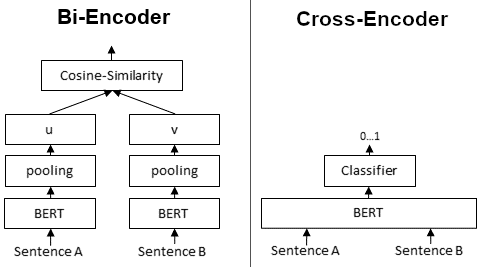

<br>

In [38]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [39]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [40]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [41]:
scores

array([  3.8467607, -11.252879 ], dtype=float32)

In [42]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [43]:
cross_rerank_scores

array([ 7.9116044 ,  5.7453213 ,  0.36677697,  1.27026   ,  4.4304028 ,
       -0.05992164,  3.8574548 ,  3.2611885 ,  0.15688857,  2.1836886 ],
      dtype=float32)

In [44]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [45]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,23,PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.21650768669715825,"{'Page_No.': 'Page 26', 'Policy_Name': 'Princi...",7.911604
1,39,Section F - Individual Purchase Rights Article...,0.23758351154054486,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",5.745321
2,14,a. be actively engaged in business for profit ...,0.2502266134474574,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",0.366777
3,10,a . A licensed Doctor of Medicine (M.D.) or Os...,0.25464617549123325,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",1.270260
4,24,I f a Member's Dependent is employed and is co...,0.264647580163873,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi...",4.430403
5,19,The number of Members insured for Dependent Li...,0.26703613329114945,"{'Page_No.': 'Page 22', 'Policy_Name': 'Princi...",-0.059922
6,33,A Member's insurance under this Group Policy f...,0.27967230915805075,"{'Page_No.': 'Page 36', 'Policy_Name': 'Princi...",3.857455
7,25,Section B - Effective Dates Article 1 - Member...,0.279871984766212,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",3.261189
8,4,Section A – Eligibility Member Life Insurance ...,0.2824440577660013,"{'Page_No.': 'Page 7', 'Policy_Name': 'Princip...",0.156889
9,32,Section C - Individual Terminations Article 1 ...,0.28541729935065774,"{'Page_No.': 'Page 35', 'Policy_Name': 'Princi...",2.183689


In [46]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,23,PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.21650768669715825,"{'Page_No.': 'Page 26', 'Policy_Name': 'Princi...",7.911604
1,39,Section F - Individual Purchase Rights Article...,0.23758351154054486,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",5.745321
2,14,a. be actively engaged in business for profit ...,0.2502266134474574,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",0.366777


In [47]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,23,PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.21650768669715825,"{'Page_No.': 'Page 26', 'Policy_Name': 'Princi...",7.911604
1,39,Section F - Individual Purchase Rights Article...,0.23758351154054486,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",5.745321
4,24,I f a Member's Dependent is employed and is co...,0.264647580163873,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi...",4.430403


In [48]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [49]:
top_3_RAG

,Documents,Metadatas
0,PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,"{'Page_No.': 'Page 26', 'Policy_Name': 'Princi..."
1,Section F - Individual Purchase Rights Article...,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi..."
4,I f a Member's Dependent is employed and is co...,"{'Page_No.': 'Page 27', 'Policy_Name': 'Princi..."


## 6. <font color = red> Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [50]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_completion_tokens=500
    )

    return response.choices[0].message.content.split('\n')

In [51]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [52]:
# Print the response

print("\n".join(response))

Based on the documents provided, the eligibility requirements for a member to qualify for life insurance coverage under this group policy are as follows:

| Eligibility Requirement                       | Description                                      |
|---------------------------------------------- |------------------------------------------------- |
| Member must be actively employed              | The member must be actively employed to qualify for life insurance coverage under this group policy. |
| Dependents must meet certain criteria         | If a Member's dependent is employed and meets specific criteria, they may also be eligible for coverage. |

**Citation:**
1. Policy Name: Principal Group Life Master Policy
   Page No.: Page 26
2. Policy Name: Principal Group Life Master Policy
   Page No.: Page 27


## 7. <font color = red> Functions for Seamantic and Generative Search


In [53]:
# Implementing Cache in Semantic Search

# Set a threshold for cache searchA

def semantic_search(input_query):
      threshold = 0.2

      ids = []
      documents = []
      distances = []
      metadatas = []
      search_df = pd.DataFrame()

      cache_results = cache_collection.query(
          query_texts=input_query,
          n_results=1
      )


      # If the distance is greater than the threshold, then return the results from the main collection.

      if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
            # Query the collection against the user query and return the top 10 results
            results = insurance_collection.query(
            query_texts=input_query,
            n_results=10
            )

            # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
            # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
            Keys = []
            Values = []

            for key, val in results.items():
              if val is None:
                continue
              if key not in ('data','embeddings','uris','included') :
                for i in range(10): # Top 10 variable, we can also put as 25 for top_n
                  Keys.append(str(key)+str(i))
                  Values.append(str(val[0][i]))


            cache_collection.add(
                documents= [input_query],
                ids = [input_query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
                metadatas = dict(zip(Keys, Values))
            )

            #print("Not found in cache. Found in main collection.")

            result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
            search_df = pd.DataFrame.from_dict(result_dict)


      # If the distance is, however, less than the threshold, you can return the results from cache

      elif cache_results['distances'][0][0] <= threshold:
            cache_result_dict = cache_results['metadatas'][0][0]

            # Loop through each inner list and then through the dictionary
            for key, value in cache_result_dict.items():
                if 'ids' in key:
                    ids.append(value)
                elif 'documents' in key:
                    documents.append(value)
                elif 'distances' in key:
                    distances.append(value)
                elif 'metadatas' in key:
                    metadatas.append(value)

            #print("Found in cache!")

            # Create a DataFrame
            search_df = pd.DataFrame({
              'IDs': ids,
              'Documents': documents,
              'Distances': distances,
              'Metadatas': metadatas
            })

      return search_df


In [54]:
def rerank_scores(input_query, search_df):
    # Input (input_query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
    # Generate the cross_encoder scores for these pairs

    cross_inputs = [[input_query, response] for response in search_df['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)

    # Store the rerank_scores in search_df
    search_df['Reranked_scores'] = cross_rerank_scores

    # Return the top 3 RAG
    top_3_rerank = search_df.sort_values(by='Reranked_scores', ascending=False)
    top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

    return top_3_RAG,search_df


In [55]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generative_search(query, top_3_RAG):
    """
    Generate a response using GPT-4o-mini's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0
    )

    return response.choices[0].message.content.split('\n')

In [56]:
def search_results_RAG(input_query):
  search_df=semantic_search(input_query)
  top_3_RAG,search_df=rerank_scores(input_query,search_df)
  response = generative_search(input_query, top_3_RAG)
  print("Query: ","\n",input_query,"\n","="*50,"\n", "Result: ")
  # Print the response
  print("\n".join(response))
  return top_3_RAG,response

## 8. <font color = red> Evaluate Sample Queries

### Query 1

In [57]:
query1=input()

What are the default benefits and provisions of the Group Policy?


In [58]:
# Generate the response - For Query 1
top_3_RAG,response=search_results_RAG(query1)

Query:  
 What are the default benefits and provisions of the Group Policy? 
 Result: 
The default benefits and provisions of the Group Policy typically include various coverage options and administrative details. Based on the relevant documents, here are some key points regarding the default benefits and provisions:

1. **Discretion of the Principal**: The Principal has complete discretion to consider various factors when administering the policy, which may affect the benefits provided.

2. **Policy Administration**: The policy outlines specific administrative procedures that must be followed, ensuring that all parties are aware of their responsibilities and the processes involved.

3. **Statutory Requirements**: There are forms and documentation that must be completed to comply with statutory requirements, which are essential for the validity of the policy.

Unfortunately, the specific details regarding the benefits and provisions were not fully detailed in the provided excerpts. For

In [59]:
# Check Top 3 results from semantic search
print("Query: ","\n",query1,"\n","="*50,"\n", "Result: ")
display(top_3_RAG)

Query:  
 What are the default benefits and provisions of the Group Policy? 
 Result: 


,Documents,Metadatas
0,T he Principal has complete discretion to cons...,"{'Page_No.': 'Page 19', 'Policy_Name': 'Princi..."
2,c . a copy of the form which contains the stat...,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi..."
1,PART II - POLICY ADMINISTRATION Section A - Co...,"{'Page_No.': 'Page 16', 'Policy_Name': 'Princi..."


### Query 2

In [60]:
query2=input()

what does it mean by 'the later of the Date of Issue'?


In [61]:
# Generate the response - For Query 2
top_3_RAG,response=search_results_RAG(query2)

Query:  
 what does it mean by 'the later of the Date of Issue'? 
 Result: 
The phrase "the later of the Date of Issue" typically refers to a specific point in time that is used to determine when certain conditions or benefits of an insurance policy become effective. It means that if there are two dates being considered—the Date of Issue and another relevant date—the policy will take effect on the later of those two dates. This is important for understanding when coverage begins or when certain benefits are activated.

For example, if the Date of Issue is January 1, 2023, and another relevant date is January 15, 2023, then the effective date for the purposes of the policy would be January 15, 2023, as it is the later date.

To find more detailed information regarding this term, you may refer to the following sections in the policy documents:

| Policy Name                     | Page Number |
|----------------------------------|-------------|
| Principal Insurance Policy       | Page 29

In [62]:
# Check Top 3 results from semantic search
print("Query: ","\n",query2,"\n","="*50,"\n", "Result: ")
display(top_3_RAG)

Query:  
 what does it mean by 'the later of the Date of Issue'? 
 Result: 


,Documents,Metadatas
5,Insurance for which Proof of Good Health is re...,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi..."
3,"(6) If, on the date a Member becomes eligible ...","{'Page_No.': 'Page 30', 'Policy_Name': 'Princi..."
9,Scheduled Benefit in force for the Member befo...,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."


### Query 3

In [63]:
query3=input()

What happens if a third-party service provider fails to provide the promised goods and services?


In [64]:
# Generate the response - For Query 3
top_3_RAG,response=search_results_RAG(query3)

Query:  
 What happens if a third-party service provider fails to provide the promised goods and services? 
 Result: 
If a third-party service provider fails to provide the promised goods and services, the consequences typically depend on the terms outlined in your insurance policy. Generally, such failures may lead to claims for damages or losses incurred due to the non-fulfillment of the service agreement. The policy may specify the procedures for filing a claim, including the necessary documentation and timelines.

In the context of your insurance policy, you may want to refer to the following sections for more detailed information:

| Policy Name                     | Page Number |
|----------------------------------|-------------|
| Principal Insurance Policy       | Page 23    |
| Principal Insurance Policy       | Page 54    |
| Principal Insurance Policy       | Page 32    |

These sections may provide insights into the claim requirements and the implications of third-party ser

In [65]:
# Check Top 3 results from semantic search
print("Query: ","\n",query3,"\n","="*50,"\n", "Result: ")
display(top_3_RAG)

Query:  
 What happens if a third-party service provider fails to provide the promised goods and services? 
 Result: 


,Documents,Metadatas
2,Section C - Policy Termination Article 1 - Fai...,"{'Page_No.': 'Page 23', 'Policy_Name': 'Princi..."
0,"f . claim requirements listed in PART IV, Sect...","{'Page_No.': 'Page 54', 'Policy_Name': 'Princi..."
8,(1) marriage or establishment of a Civil Union...,"{'Page_No.': 'Page 32', 'Policy_Name': 'Princi..."


<div align="center" > <b>-------- End of Notebook ---------</b> </div>